In [1]:
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo
from dbc.main import KmeansDiscreteMinimaxClassifier, CmeansDiscreteMinmaxClassifier
from dbc import compute_conditional_risk

In [2]:
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets.values.ravel()
y = LabelEncoder().fit_transform(y)

In [24]:
# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets
y = LabelEncoder().fit_transform(y)

D:\program\Miniconda3\envs\RML\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [2]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets
y = LabelEncoder().fit_transform(y)

D:\program\Miniconda3\envs\RML\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
y

,quality
0,5
1,5
2,5
3,6
4,5
...,...
6492,6
6493,5
6494,6
6495,7


In [25]:
from dbc.utils import compute_SPDBC_pi_star
from dbc import CmeansDiscreteBayesianClassifier
T = 10
fuzzifier = 2
DMC = KmeansDiscreteMinimaxClassifier(n_clusters=T)
DMC.fit(X, y)

SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
# SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier)
SPDBC.fit(X, y)

y_pred_DMC = DMC.predict(X)
risks_DMC = compute_conditional_risk(y, y_pred_DMC)[0]

pi_star_SPDBC, risk_history = compute_SPDBC_pi_star(X, y, SPDBC.loss_function, SPDBC.p_hat, SPDBC.membership_degree, SPDBC.prior, alpha=2, n_iter=300, eps=1e-3, return_history=True)

y_pred_SPDBC = SPDBC.predict(X, prior_pred=pi_star_SPDBC)
risks_SPDBC = compute_conditional_risk(y, y_pred_SPDBC)[0]

print("DMC empirical class conditional risk:\n", risks_DMC, "\n")
print("SPDEC empirical class conditional risk:\n", risks_SPDBC, "\n")

DMC empirical class conditional risk:
 [0.   0.08 0.02] 

SPDEC empirical class conditional risk:
 [0.   0.02 0.02] 



In [26]:
y_pred_DMC

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

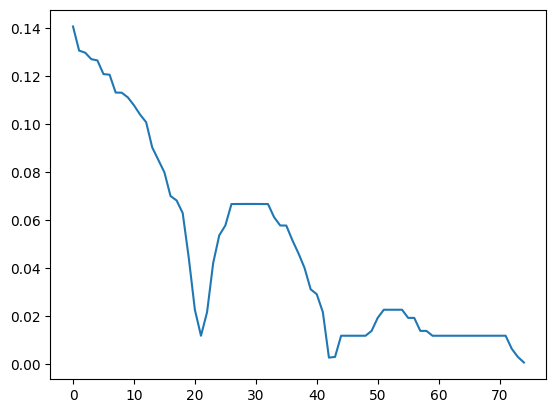

In [4]:

from matplotlib import pyplot as plt
plt.plot(risk_history)

In [3]:

T = 10
fuzzifier = 2
DMC = KmeansDiscreteMinimaxClassifier(n_clusters=T)
DMC.fit(X, y)
y_pred_DMC = DMC.predict(X)
risks_DMC = compute_conditional_risk(y, y_pred_DMC)[0]



print("DMC empirical class conditional risk:\n", risks_DMC, "\n")



DMC empirical class conditional risk:
 [0.8        0.86574074 0.73900842 0.69957687 0.8257646  0.63212435
 1.        ] 



D:\program\Miniconda3\envs\RML\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\program\Miniconda3\envs\RML\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\program\Miniconda3\envs\RML\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\program\Miniconda3\envs\RML\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\program\Miniconda3\envs\RML\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

In [4]:
SPDMC = CmeansDiscreteMinmaxClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
SPDMC.fit(X, y)
y_pred_SPDMC = SPDMC.predict(X)
risks_SPDMC = compute_conditional_risk(y, y_pred_SPDMC)[0]
print("SPDMC empirical class conditional risk:\n", risks_SPDMC, "\n")

SPDMC empirical class conditional risk:
 [0.76666667 0.77314815 0.78110384 0.78737659 0.77479147 0.78238342
 0.8       ] 



In [42]:
y

array([2, 2, 2, ..., 3, 4, 3])